# Superhero Attributes and Power Classification

**DSCI 4411 - Fundamentals of Data Mining**  
**The American University in Cairo - Fall 2025**

This project explores classification and clustering techniques using a dataset of superheroes with various attributes such as powers, skills, physical traits, and biography data.

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Load the dataset
df = pd.read_csv('superhero dataset.csv')
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (1200, 17)


,height_cm,weight_kg,age,years_active,training_hours_per_week,civilian_casualties_past_year,power_level,public_approval_rating,super_strength,flight,energy_projection,telepathy,healing_factor,shape_shifting,invisibility,telekinesis,is_good
0,189.9,81.9,33,10,32.6,2,28.4,62.9,0,1,0,1,0,0,1,1,1
1,177.2,73.6,58,22,41.9,2,67.3,41.4,0,0,0,0,0,0,1,0,1
2,193.0,81.8,47,6,22.3,0,95.9,96.8,0,1,0,0,0,1,1,0,0
3,210.5,88.1,62,26,25.0,4,71.8,53.2,1,0,0,1,0,0,0,0,1
4,175.3,80.7,43,28,24.9,3,81.3,36.1,0,0,0,1,1,1,1,1,0


## 2. Exploratory Data Analysis (EDA)

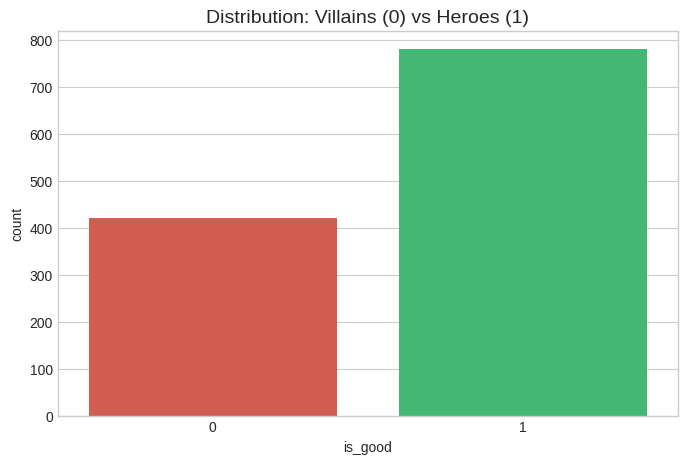

In [3]:
# Create figures directory
import os
os.makedirs('figures', exist_ok=True)

# Target variable distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='is_good', palette=['#e74c3c', '#2ecc71'])
plt.title('Distribution: Villains (0) vs Heroes (1)', fontsize=14)
plt.savefig('figures/target_distribution.png')
plt.show()

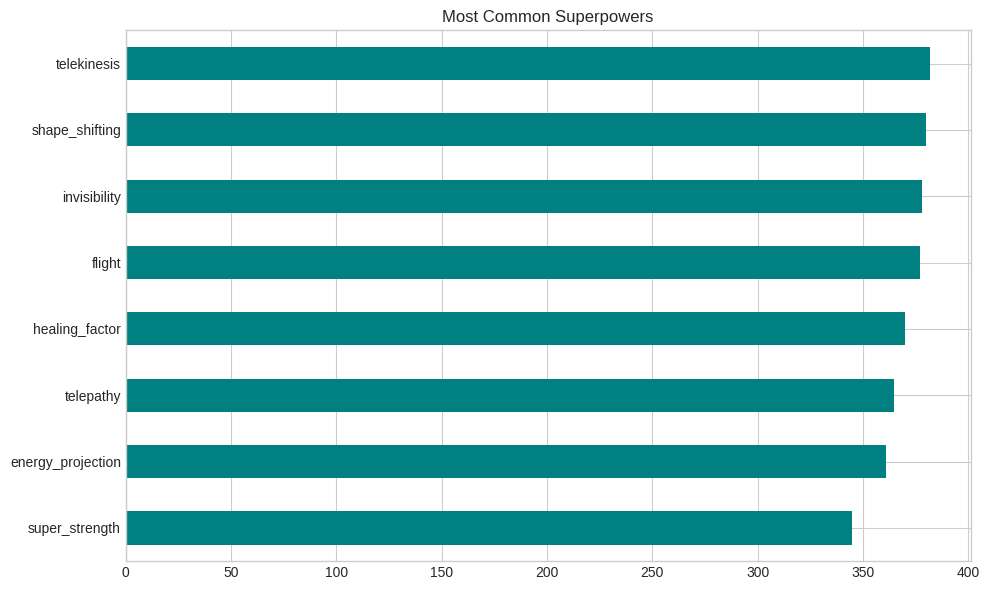

In [4]:
# Power distribution analysis
power_cols = ['super_strength', 'flight', 'energy_projection', 'telepathy', 
              'healing_factor', 'shape_shifting', 'invisibility', 'telekinesis']

power_counts = df[power_cols].sum().sort_values(ascending=True)

plt.figure(figsize=(10, 6))
power_counts.plot(kind='barh', color='teal')
plt.title('Most Common Superpowers')
plt.tight_layout()
plt.savefig('figures/power_distribution.png')
plt.show()

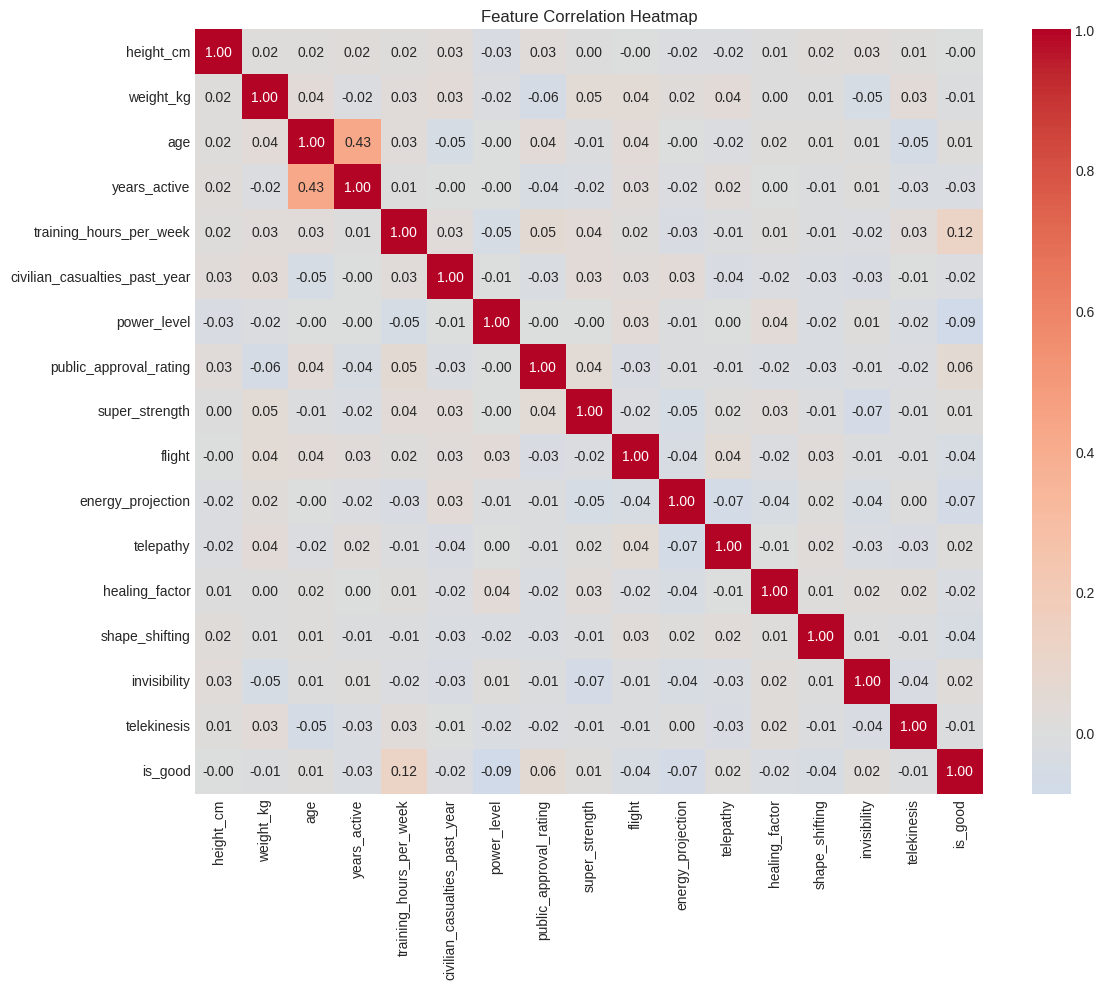

In [5]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('figures/correlation_heatmap.png')
plt.show()

## 3. Classification Models (Predicting Hero vs Villain)

In [6]:
# Prepare features
X = df.drop('is_good', axis=1)
y = df['is_good']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Logistic Regression Accuracy: 0.6500
Random Forest Accuracy: 0.6458


SVM Accuracy: 0.6208


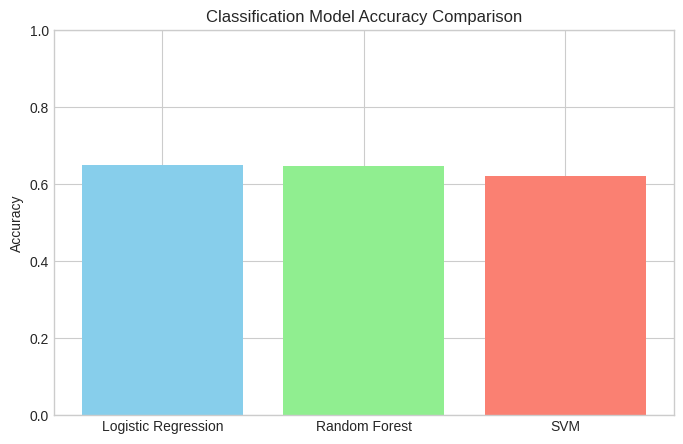

In [7]:
# Train Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

results = {}

for name, model in models.items():
    # Use scaled data for LR and SVM
    if name in ['Logistic Regression', 'SVM']:
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
    acc = accuracy_score(y_test, pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

# Visualize Comparison
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1.0)
plt.title('Classification Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.savefig('figures/model_comparison.png')
plt.show()

## 4. Clustering Analysis (Identifying Archetypes)

In [8]:
# FEATURE SELECTION FOR CLUSTERING
# We select features that define behavior and power, excluding noisy physical traits
cluster_features = [
    'power_level', 
    'public_approval_rating', 
    'civilian_casualties_past_year',
    'is_good',  # Included to help separate hero/villain clusters
    'training_hours_per_week'
] + power_cols

X_cluster = df[cluster_features].copy()
X_cluster_scaled = scaler.fit_transform(X_cluster)

print("Selected features for clustering:", cluster_features)

Selected features for clustering: ['power_level', 'public_approval_rating', 'civilian_casualties_past_year', 'is_good', 'training_hours_per_week', 'super_strength', 'flight', 'energy_projection', 'telepathy', 'healing_factor', 'shape_shifting', 'invisibility', 'telekinesis']


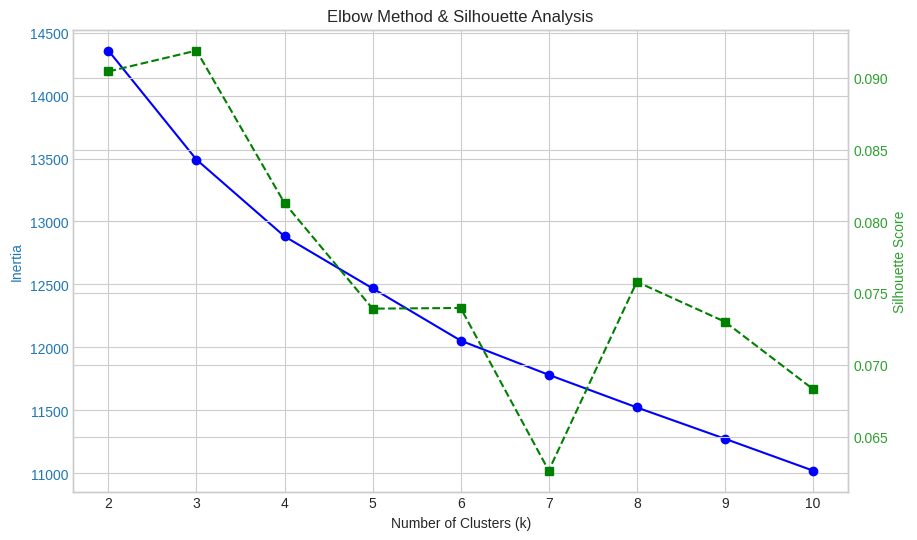

In [9]:
# Determine optimal k with Elbow Method + Silhouette
inertias = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_cluster_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_cluster_scaled, labels))

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.plot(k_range, inertias, 'bo-', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:green')
ax2.plot(k_range, sil_scores, 'gs--', label='Silhouette')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('Elbow Method & Silhouette Analysis')
plt.savefig('figures/elbow_silhouette.png')
plt.show()

In [10]:
# Perform Clustering with k=4 (Chosen based on score and interpretability)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df['cluster'] = kmeans.fit_predict(X_cluster_scaled)

print(f"Clustering complete with k={optimal_k}. Silhouette Score: {silhouette_score(X_cluster_scaled, df['cluster']):.4f}")

Clustering complete with k=4. Silhouette Score: 0.0813


In [11]:
# Cluster Profiling & Naming Logic
profile = df.groupby('cluster')[['is_good', 'power_level', 'public_approval_rating', 'civilian_casualties_past_year']].mean()
print("Cluster Profiles:")
display(profile)

# Automated Naming Logic
archetypes = {}
for c in profile.index:
    row = profile.loc[c]
    name = []
    
    # Villain vs Hero determination
    if row['is_good'] < 0.4:
        base = "Villain"
    elif row['is_good'] > 0.6:
        base = "Hero"
    else:
        base = "Anti-Hero"
        
    # Power/Approval qualifiers
    if row['power_level'] > 60 and row['civilian_casualties_past_year'] > 4:
        qualifier = "Destructive"
    elif row['public_approval_rating'] > 60:
        qualifier = "Public"
    elif row['power_level'] > 70:
        qualifier = "Powerhouse"
    else:
        qualifier = "Street-Level"
        
    archetypes[c] = f"{qualifier} {base}"

df['archetype'] = df['cluster'].map(archetypes)

print("\nDiscovered Archetypes:")
print(df['archetype'].value_counts())

Cluster Profiles:


,is_good,power_level,public_approval_rating,civilian_casualties_past_year
cluster,,,,
0,0.000000,71.295455,61.601364,2.059091
1,0.662791,70.089535,65.883721,1.997093
2,1.000000,68.936053,65.148158,1.776316
3,0.671875,71.200391,64.712500,1.785156



Discovered Archetypes:
archetype
Public Hero       980
Public Villain    220
Name: count, dtype: int64


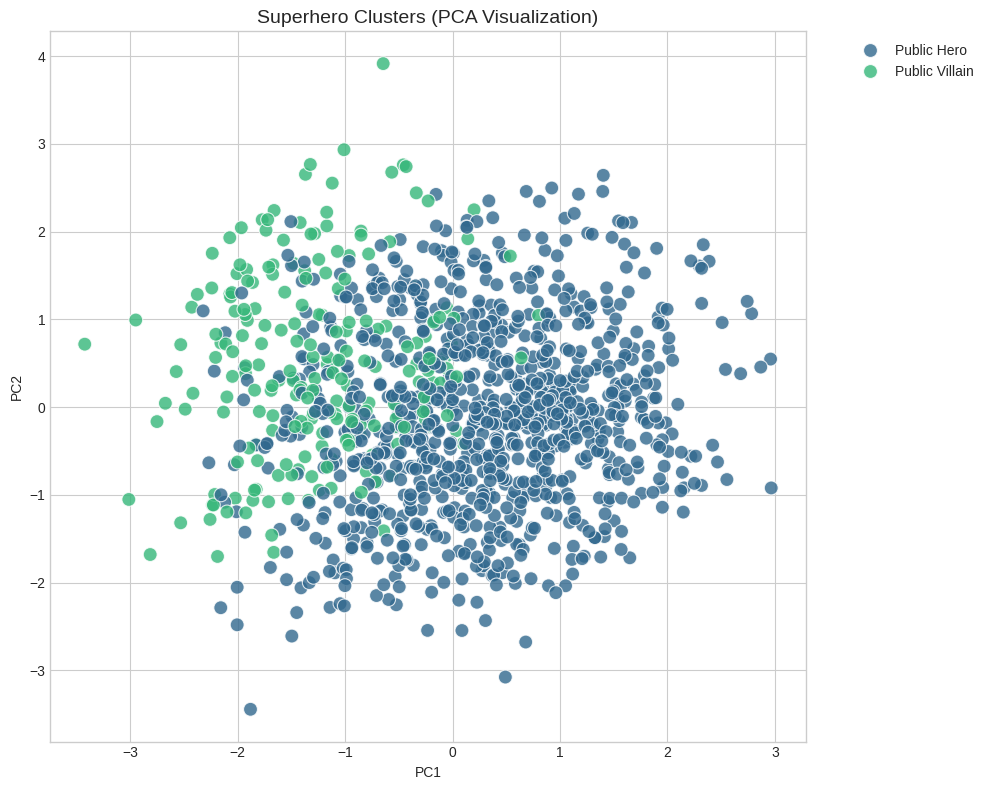

In [12]:
# PCA Visualization
pca = PCA(n_components=2)
pca_res = pca.fit_transform(X_cluster_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_res[:,0], y=pca_res[:,1], hue=df['archetype'], palette='viridis', s=100, alpha=0.8)
plt.title('Superhero Clusters (PCA Visualization)', fontsize=14)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('figures/cluster_pca_final.png')
plt.show()

In [13]:
# Save Results
df.to_csv('superhero_clusters_final.csv', index=False)
print("Results saved to superhero_clusters_final.csv")

Results saved to superhero_clusters_final.csv
